In [ ]:
# default_exp image

# ImageFeatureExtractor
> Use transfer learning models to convert images into vectors with features

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
#hide_output
# All Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFile
import glob
ImageFile.LOAD_TRUNCATED_IMAGES = True #https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torchvision.transforms as transforms

# All Parameters


# Functions and classes
def download_dataset(data_url, zip_filename):
    try: # Then try downloading and unzipping it
        print("Downloading Dataset...")
        os.system(f"wget {data_url}")

        print("Unzipping Dataset")
        if 'tgz' in zip_filename:
            os.system(f"tar -xvzf {zip_filename}")
        else:
            os.system(f"unzip {zip_filename}")

        print("Removing .zip file")
        os.system(f"rm {zip_filename}")
    except Exception as e: # If there's an error, ask to download manually
        print(f"Something went wrong. Please download the dataset manually at {data_url}")
        print(f'The following exception was thrown:\n{e}')

    
class ImageFeatureExtractor():
    def __init__(self, model_name='resnet', target_shape=(224, 224, 3)):
        self.target_shape = target_shape
        self.model = self._get_model(model_name)
        self.model_name = model_name

    def _center_crop_img(self, img, size=224): #using pytorch as it gives more freedom in the transformations
        tr = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
        ])  
        return tr(img)
    
    def _preprocess_img(self, img):
        img=self._center_crop_img(img, size=self.target_shape[0])
        
        # Convert to a Numpy array
        img_np = np.asarray(img)

        # Reshape by adding 1 in the beginning to be compatible as input of the model
        img_np = img_np[None] # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis

        # Prepare the image for the model
        img_np = self.preprocess_input(img_np)

        return img_np

    def _get_model(self, model_name):
        if model_name=='resnet':
            self.preprocess_input = resnet50.preprocess_input
            
            base_model = resnet50.ResNet50(include_top=False, 
                                           input_shape=self.target_shape)
            
            for layer in base_model.layers:
                layer.trainable=False

            model = Sequential([base_model,
                                GlobalAveragePooling2D()])

            return model
        
        elif model_name=='efficientnetb0':
            self.preprocess_input = efficientnet.preprocess_input
            base_model = EfficientNetB0(include_top=False,
                                        input_shape=self.target_shape)
            
            for layer in base_model.layers:
                layer.trainable=False

            model = Sequential([base_model,
                                GlobalAveragePooling2D()])

            return model
        
        
        return None

    def _get_img_gen_from_df(self, dataframe, batch_size=32):

        datagen = ImageDataGenerator(preprocessing_function=self.preprocess_input)

        gen = datagen.flow_from_dataframe(dataframe,
                                          batch_size=batch_size,
                                          target_size=self.target_shape[:2], 
                                          class_mode=None,
                                          shuffle=False)
        return gen

    def _get_img_gen(self, folder_path, batch_size=32):
        datagen = ImageDataGenerator(preprocessing_function=self.preprocess_input)
        gen = datagen.flow_from_directory(folder_path,
                                          batch_size=batch_size,
                                          target_size=self.target_shape[:2], 
                                          class_mode='sparse',
                                          shuffle=False)
        return gen
    
    def _assert_df_size(self, dataframe):
        assert len(dataframe)>0, "Folder not found or does not have images. If there's one folder per class, please make sure to set classes_as_folders to True"

    def read_img_url(self, url, center_crop=True):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if center_crop:
            img = self._center_crop_img(img, size=self.target_shape[0])
        return img
    
    def read_img_path(self, img_path, center_crop=True):
        img = image.load_img(img_path)
        if center_crop:
            img = self._center_crop_img(img, size=self.target_shape[0])
        return img
    
    def url_to_vector(self, url):
        img = self.read_img_url(url)
        vector = self.img_to_vector(img)
        return vector
    
    def img_path_to_vector(self, img_path):
        img = self.read_img_path(img_path)
        vector = self.img_to_vector(img)
        return vector
    
    def img_to_vector(self, img):
        img_np = self._preprocess_img(img)
        vector = self.model.predict(img_np)
        return vector

    def _get_gen(self, classes_as_folders, directory, batch_size):
        if classes_as_folders:
            gen = self._get_img_gen(directory, batch_size)
        else:
            filepaths = glob.glob(directory+'/*.*')
            self.dataframe=pd.DataFrame(filepaths, 
                                        columns=['filename'])
            self._assert_df_size(self.dataframe)
            gen = self._get_img_gen_from_df(self.dataframe, 
                                            batch_size)
        return gen

    def _vectors_to_df(self, all_vectors, classes_as_folders, export_class_names):
        vectors_df=pd.DataFrame(all_vectors)
        vectors_df.insert(loc=0, column='filepaths', value=self.gen.filepaths)
        if classes_as_folders and export_class_names:
            vectors_df.insert(loc=1, column='classes', value=self.gen.classes)
            id_to_class = {v: k for k, v in self.gen.class_indices.items()}
            vectors_df.classes=vectors_df.classes.apply(lambda x: id_to_class[x])
        return vectors_df
    
    def extract_features_from_directory(self, 
                                        directory, 
                                        batch_size=32, 
                                        classes_as_folders=True, 
                                        export_class_names=False,
                                        export_vectors_as_df=True):
        # Get image generator
        self.gen = self._get_gen(classes_as_folders, directory, batch_size)
        
        # Extract features into vectors
        self.all_vectors=self.model.predict(self.gen, verbose=1)
        
        # Either return vectors or everything as dataframes
        if not export_vectors_as_df:
            return self.all_vectors
        else:
            vectors_df = self._vectors_to_df(self.all_vectors, classes_as_folders, export_class_names)
            return vectors_df

    def vectors_from_folder_list(self, folder_list):
        df_list = []
        for folder_path in folder_list:
            df=self.img_folder_to_vectors(folder_path)
            df_list.append(df)
        return pd.concat(df_list)


## Converting Image to Vector

16719872/16705208 [==============================] - 1s 0us/step


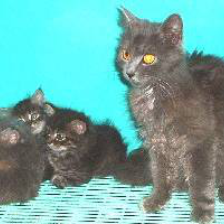

In [ ]:
ife = ImageFeatureExtractor(model_name='efficientnetb0')
url='https://raw.githubusercontent.com/WittmannF/ImageDataGenerator-example/master/flow_from_dataframe/train/cat.101.jpg'
img=ife.read_img_url(url)
img

In [ ]:
ife.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
vector=ife.img_to_vector(img)
vector

array([[-0.01482432, -0.05527921,  0.23075758, ...,  0.53876066,
         0.51287   , -0.053831  ]], dtype=float32)

In [ ]:
vector.shape

(1, 1280)

In [ ]:
df=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/train/cat',
                                       classes_as_folders=False)
df.head()

Found 128 validated image filenames.


2021-10-06 11:18:14.455687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 179ms/step


filepaths         0         1  \
0   ./sample_data/cats_vs_dogs/train/cat/cat.6.jpg  0.225212  0.058640   
1  ./sample_data/cats_vs_dogs/train/cat/cat.30.jpg  0.202250  0.160452   
2  ./sample_data/cats_vs_dogs/train/cat/cat.24.jpg  0.200531 -0.030708   
3  ./sample_data/cats_vs_dogs/train/cat/cat.18.jpg  0.230099  0.081425   
4  ./sample_data/cats_vs_dogs/train/cat/cat.19.jpg  0.070455 -0.092657   

          2         3         4         5         6         7         8  ...  \
0 -0.095501 -0.073367  1.321245  0.074913  0.470487 -0.012128  0.598165  ...   
1  0.557351 -0.085632 -0.105077  0.298232  0.134021  0.112814 -0.054420  ...   
2 -0.143709 -0.012947 -0.012103  0.094327 -0.082119 -0.095636  0.067225  ...   
3  0.335069 -0.099280  0.002416 -0.154609 -0.161813 -0.096908 -0.139070  ...   
4 -0.064933 -0.109489 -0.021460 -0.124329  0.626454  0.006053 -0.146398  ...   

       1270      1271      1272      1273      1274      1275      1276  \
0 -0.112729 -0.122853  0.436117 -0.026819 -0.091265  0.064628  0.315744   
1  0.039416 -0.137677  0.114761  0.092318  0.287135  0.156551 -0.152136   
2 -0.033623 -0.080547  0.466413  0.051606  0.061862 -0.129659 -0.135904   
3  0.028308 -0.209473 -0.039060 -0.077227 -0.084279 -0.004354  0.241149   
4 -0.028919 -0.058245 -0.126074 -0.084243 -0.021173  0.039658 -0.139905   

       1277      1278      1279  
0 -0.017118 -0.146257  0.295975  
1  0.054678 -0.113809 -0.012793  
2  0.200370 -0.130808 -0.067054  
3 -0.130906  0.188262 -0.114258  
4  0.121402 -0.110747  0.217937  

[5 rows x 1281 columns]

In [ ]:
df=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/train',
                                       export_class_names=True,
                                       classes_as_folders=True)
df.head()

Found 256 images belonging to 2 classes.


2021-10-06 11:18:18.266867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 213ms/step


filepaths classes         0  \
0    ./sample_data/cats_vs_dogs/train/cat/cat.0.jpg     cat  0.456551   
1    ./sample_data/cats_vs_dogs/train/cat/cat.1.jpg     cat  0.087864   
2   ./sample_data/cats_vs_dogs/train/cat/cat.10.jpg     cat  0.023569   
3  ./sample_data/cats_vs_dogs/train/cat/cat.100.jpg     cat  0.059996   
4  ./sample_data/cats_vs_dogs/train/cat/cat.101.jpg     cat -0.041377   

          1         2         3         4         5         6         7  ...  \
0 -0.036920 -0.117857 -0.120442  0.090476  0.630952  0.282625 -0.117053  ...   
1 -0.109384 -0.148388  0.087301 -0.108840 -0.112653 -0.105029 -0.191852  ...   
2  0.194844 -0.012433 -0.037307 -0.084910 -0.033898  0.274007 -0.135142  ...   
3  0.440460 -0.110263 -0.148372 -0.152904 -0.107543 -0.065826 -0.107320  ...   
4 -0.043872  0.098374 -0.107689  0.156048  0.118467 -0.022955 -0.158435  ...   

       1270      1271      1272      1273      1274      1275      1276  \
0  0.020791 -0.032444  0.279972 -0.100614  0.126624 -0.144146 -0.138254   
1 -0.097658 -0.096658 -0.108985 -0.061243  0.043187  0.166429 -0.119754   
2 -0.079801 -0.182763  0.060846 -0.094208  0.043399  0.149070 -0.105733   
3 -0.064428 -0.170988  0.088787 -0.104232  0.347278  0.661745 -0.055814   
4 -0.037849 -0.118383  0.009495 -0.067195  0.145152  0.102556 -0.114290   

       1277      1278      1279  
0  0.226428 -0.159525 -0.007993  
1  0.636140 -0.167608 -0.118658  
2 -0.118275 -0.087090  0.005981  
3 -0.098556 -0.202804 -0.133524  
4  0.040539  0.178128 -0.122962  

[5 rows x 1282 columns]

## Training a ML Model

In [ ]:
train=df

test=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/valid',
                                         export_class_names=True,
                                         classes_as_folders=True)

Found 64 images belonging to 2 classes.
2/2 [==============================] - 0s 231ms/step


In [ ]:
X_train, y_train = train.drop(['filepaths', 'classes'], axis=1), train['classes']

In [ ]:
X_test, y_test = test.drop(['filepaths', 'classes'], axis=1), test['classes']

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression().fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

1.0

<AxesSubplot:>

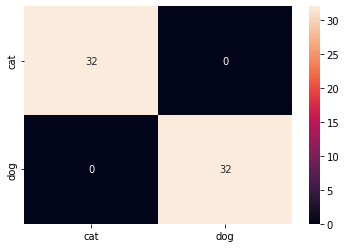

In [ ]:
import seaborn as sns
y_pred=lr.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            xticklabels=lr.classes_,
            yticklabels=lr.classes_)

## Customizing Model

In [ ]:
ife = ImageFeatureExtractor(model_name=None)


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

model=VGG16(weights='imagenet', include_top=False)
ife.model=model
ife.preprocess_input=preprocess_input

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
vector=ife.img_to_vector(img)

2021-10-06 11:22:24.688204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
vector.shape

(1, 7, 7, 512)

In [ ]:
features=ife.extract_features_from_directory('./sample_data/cats_vs_dogs/train/cat',
                                            classes_as_folders=False,
                                            export_vectors_as_df=False)
features.shape

Found 128 validated image filenames.


2021-10-06 11:22:31.246580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 604ms/step


(128, 7, 7, 512)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
ife.model=model
ife.preprocess_input=preprocess_input

574726144/574710816 [==============================] - 23s 0us/step


In [ ]:
vector=ife.img_to_vector(img)
vector

2021-10-06 11:23:04.827308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.       , 0.       , 2.0117116, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
vector.shape

(1, 4096)

### Things to consider changing
- Load image method from pytorch to keras
  - Problem: cant control the preprocessing method, images are resized instead of a center-crop method
  - Advantage: Remove dependency of pytorch, also, images that are loaded from folder will be preprocessed by keras anyway
  - Decision: Keep both, no big deal having extra dependency

- update `extract_features_from_directory` to `img_folder_to_vectors`
  - this way naming will be more consistent
      - However, examples will have to be updated
  - extract_features vs xxx_to_vectors vs xx_to_embedding vs directory_to_vectors

In [ ]:
!cat notes.txt

https://nbdev.fast.ai/example.html

Things missing:
- Review naming terminology
- Updateextract_features_from_directory to from_directory
- include_classes-> export_classes
